In [1]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [2]:
forestfile = "/home/glemieux/Repos/fates/tools/landuse/tests/resources/CLM5_current_luhforest_deg025.nc"
staticfile = "/home/glemieux/Repos/fates/tools/landuse/tests/resources/staticData_quarterdeg.nc"
otherfile = "/home/glemieux/Data/luh2/lu-pft/CLM5_current_luhother_deg025.nc"

In [3]:
ds_static = xr.open_dataset(staticfile)
ds_forest = xr.open_dataset(forestfile)
ds_other = xr.open_dataset(otherfile)

In [4]:
ds_forest['lat'] = ds_forest.lat * 0.25 - 90. + 1./8.
ds_other['lat']  = ds_other.lat * 0.25 - 90. + 1./8.

ds_forest['lon'] = ds_forest.lon * 0.25 - 180. + 1./8.
ds_other['lon']  = ds_other.lon * 0.25 - 180. + 1./8.

In [5]:
fstnf = ds_static.fstnf.astype('float64')
icwtr = ds_static.icwtr.astype('float64')
# fstnf = ds_static.fstnf
# icwtr = ds_static.icwtr

In [6]:
mask_static = (1.-icwtr) / (1.-icwtr)
mask_non_forest = (1. - fstnf)

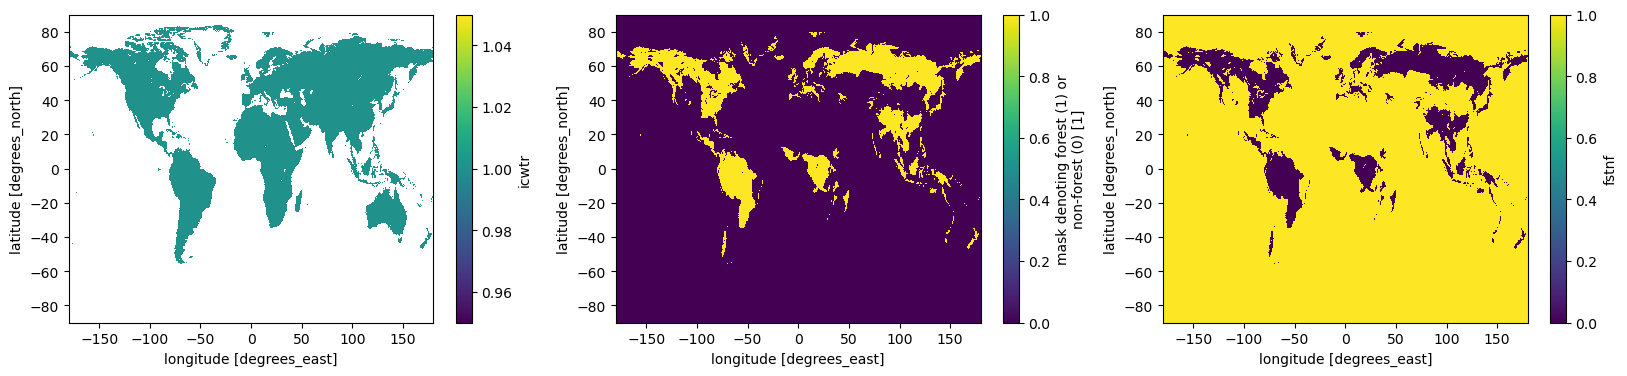

In [7]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
mask_static.plot(ax=ax1)
fstnf.plot(ax=ax2)
mask_non_forest.plot(ax=ax3)

In [8]:
pct_nat_pft_forest = ds_forest.PCT_NAT_PFT.astype('float64').isel(natpft=slice(1,None))
# pct_nat_pft_forest = ds_forest.PCT_NAT_PFT.isel(natpft=slice(1,None))
pct_nat_pft_forest = pct_nat_pft_forest / pct_nat_pft_forest.sum(dim='natpft')
# pct_nat_pft_forest_new = ds_forest.PCT_NAT_PFT.isel(natpft=slice(1,None)) / ds_forest.PCT_NAT_PFT.isel(natpft=slice(1,None)).sum(dim='natpft') * 100. * landoceanmask

pct_nat_pft_other = ds_other.PCT_NAT_PFT.astype('float64').isel(natpft=slice(1,None))
# pct_nat_pft_other = ds_other.PCT_NAT_PFT.isel(natpft=slice(1,None))
pct_nat_pft_other = pct_nat_pft_other / pct_nat_pft_other.sum(dim='natpft')

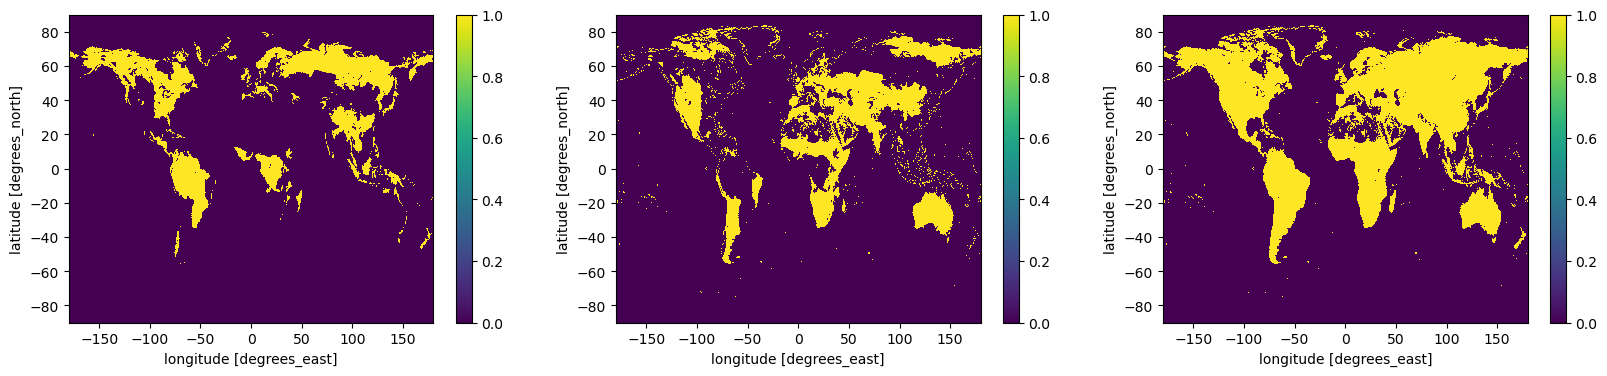

In [10]:
pripct = fstnf * pct_nat_pft_forest
secpct = mask_non_forest * pct_nat_pft_other
prisecpct = pripct + secpct
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
pripct.sum(dim='natpft').plot(ax=ax1)
secpct.sum(dim='natpft').plot(ax=ax2)
prisecpct.sum(dim='natpft').plot(ax=ax3)

/tmp/ipykernel_339529/1330115250.py:5: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in fg.axes.flat:


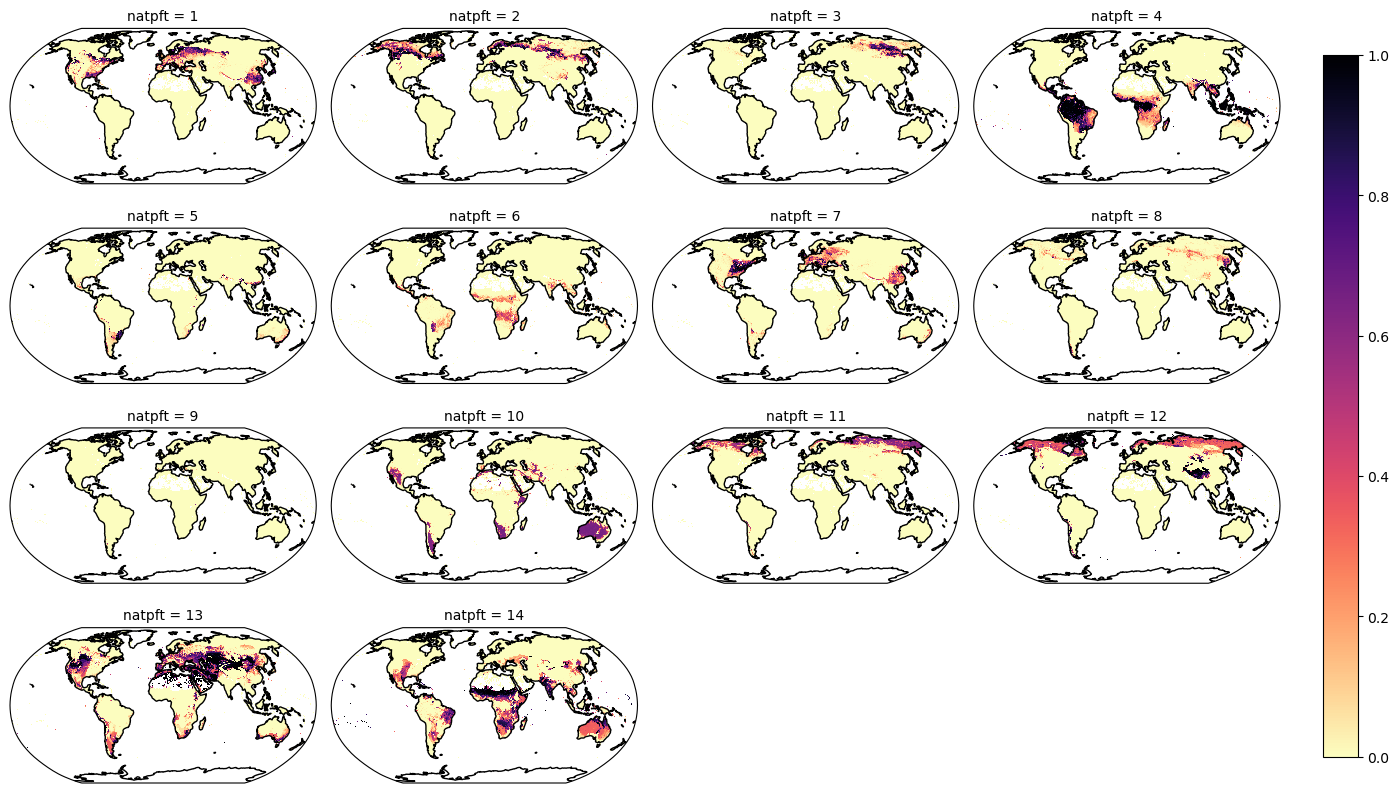

In [11]:
# from Charlie's notebook
fg = prisecpct.plot(x='lon',y='lat',col='natpft', col_wrap=4, cmap='magma_r', 
                   transform=ccrs.PlateCarree(), subplot_kws=dict(projection=ccrs.Robinson()), add_colorbar=False)

for ax in fg.axes.flat:
    ax.coastlines() 

# color bar
fg.add_colorbar(orientation="vertical", shrink=0.6, anchor=(1.5, 0.5))
plt.subplots_adjust(hspace=-0.65)